In [1]:
# Librerie base
import numpy as np
import pandas as pd

# Visualizzazione
import matplotlib.pyplot as plt  
import seaborn as sns

# Modelli statistici
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

# Libreria ISLP (Statistical Learning)
from ISLP import load_data
from ISLP.models import (ModelSpec as MS ,summarize, poly)

# Simple Linear Regression
We will use the Boston housing dataset, contained in the ISLP package. The Boston dataset records the medv (average house value) for 506 neighbourhoods around Boston.

In [ ]:
# carico il dataset e stampo l'head
taxi = pd.read_csv("water_pollution_disease.csv", encoding='utf-8')
target = 'Trip_Price'

In [264]:
taxi.columns

Index(['Trip_Distance_km', 'Time_of_Day', 'Day_of_Week', 'Passenger_Count',
       'Traffic_Conditions', 'Weather', 'Base_Fare', 'Per_Km_Rate',
       'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price'],
      dtype='object')

In [265]:
#look at the first 5 rows in the datasets
taxi.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


In [266]:
print(taxi.describe())

       Trip_Distance_km  Passenger_Count   Base_Fare  Per_Km_Rate  \
count        950.000000       950.000000  950.000000   950.000000   
mean          27.070547         2.476842    3.502989     1.233316   
std           19.905300         1.102249    0.870162     0.429816   
min            1.230000         1.000000    2.010000     0.500000   
25%           12.632500         1.250000    2.730000     0.860000   
50%           25.830000         2.000000    3.520000     1.220000   
75%           38.405000         3.000000    4.260000     1.610000   
max          146.067047         4.000000    5.000000     2.000000   

       Per_Minute_Rate  Trip_Duration_Minutes  Trip_Price  
count       950.000000             950.000000  951.000000  
mean          0.292916              62.118116   56.874773  
std           0.115592              32.154406   40.469791  
min           0.100000               5.010000    6.126900  
25%           0.190000              35.882500   33.742650  
50%           0.29

In [267]:
# Controllo i dati nulli
columnsWithNulls=taxi.isnull().sum().sort_values(ascending=False)
columnsWithNulls=columnsWithNulls[columnsWithNulls>0]
print(columnsWithNulls)

Trip_Distance_km         50
Time_of_Day              50
Day_of_Week              50
Passenger_Count          50
Traffic_Conditions       50
Weather                  50
Base_Fare                50
Per_Km_Rate              50
Per_Minute_Rate          50
Trip_Duration_Minutes    50
Trip_Price               49
dtype: int64


Trip_Distance_km         5.0
Time_of_Day              5.0
Day_of_Week              5.0
Passenger_Count          5.0
Traffic_Conditions       5.0
Weather                  5.0
Base_Fare                5.0
Per_Km_Rate              5.0
Per_Minute_Rate          5.0
Trip_Duration_Minutes    5.0
Trip_Price               4.9
dtype: float64


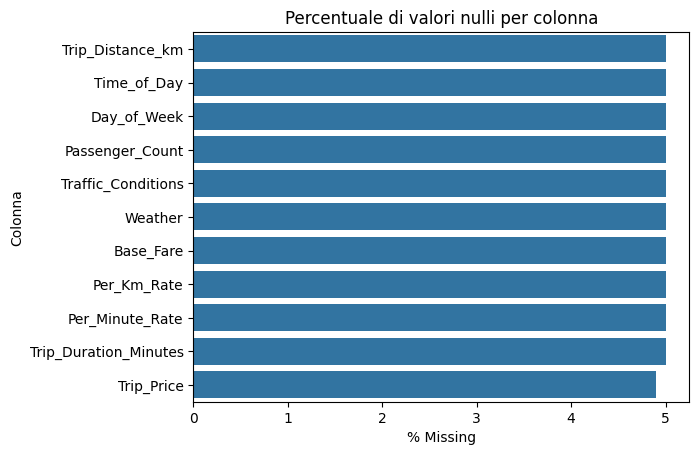

In [268]:
# Controllo in percentuale quanti dati mancano così da capire come trattarli, pongo una soglia di eliminazione del regressore nel caso di +30% di dati mancanti
missing_pct = taxi.isnull().mean() * 100
missing_only = missing_pct[missing_pct > 0].sort_values(ascending=False)
print(missing_only)
sns.barplot(x=missing_only.values, y=missing_only.index)
plt.title('Percentuale di valori nulli per colonna')
plt.xlabel('% Missing')
plt.ylabel('Colonna')
plt.show()

In [269]:
#Drop dati nulli
taxi.dropna(axis=0, inplace=True)
missing_pct = taxi.isnull().sum()
print("Number of null data: \n")
print(missing_pct)

Number of null data: 

Trip_Distance_km         0
Time_of_Day              0
Day_of_Week              0
Passenger_Count          0
Traffic_Conditions       0
Weather                  0
Base_Fare                0
Per_Km_Rate              0
Per_Minute_Rate          0
Trip_Duration_Minutes    0
Trip_Price               0
dtype: int64


## Data processing

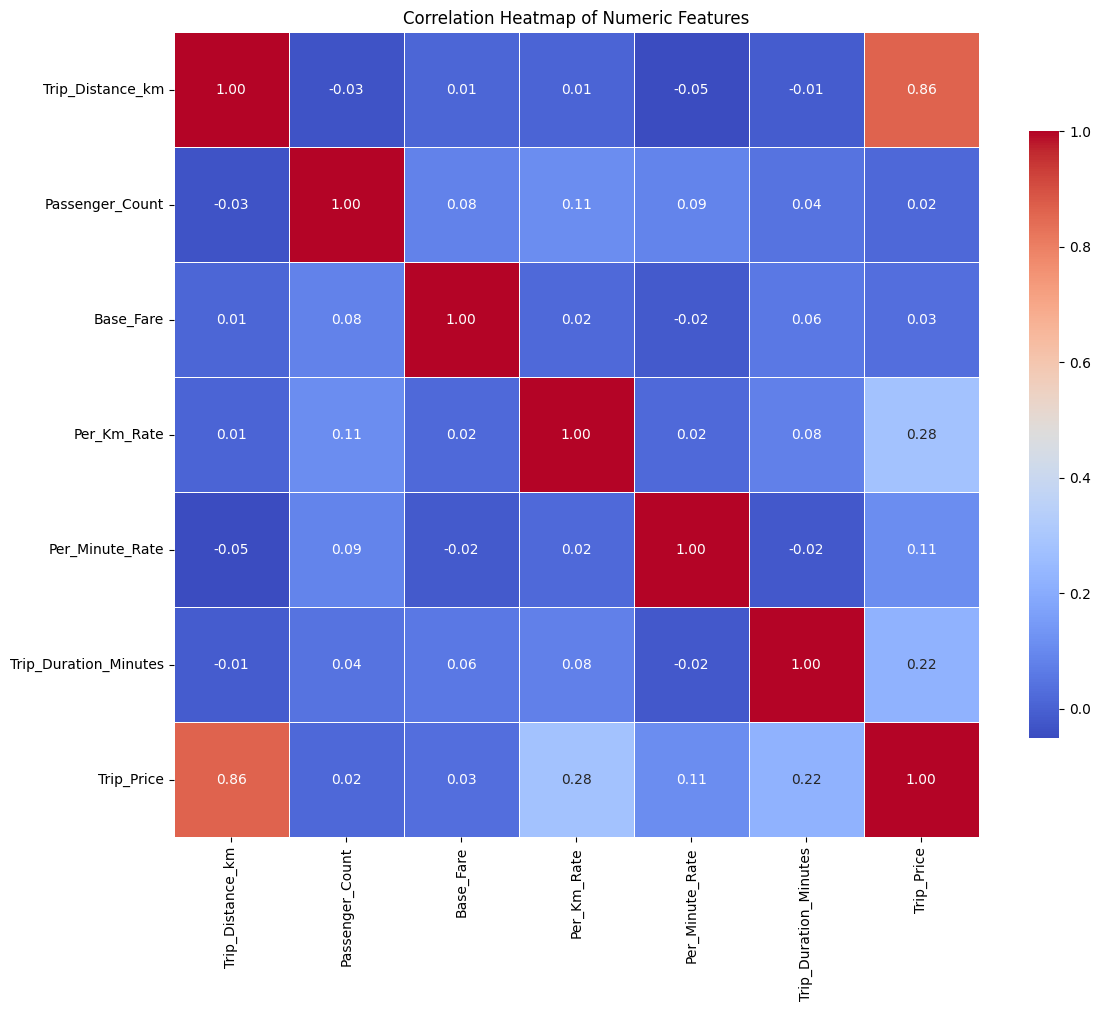

In [270]:
# Seleziona le colonne numeriche
numeric_data = taxi.select_dtypes(include=[np.number])
if numeric_data.shape[1] >= 4:
    # Calcola la matrice di correlazione
    corr = numeric_data.corr()
    
    # Imposta la figura
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        square=True,
        linewidths=.5,
        cbar_kws={"shrink": .75}
    )
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for a meaningful correlation heatmap')

### Osservo una alta correlazione tra Trip_Distance_km e Trip_Price

####  essendo Trip_Price la variabile target decido di mantenere Trip_Distance_km

## Controllo il VIF

In [271]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
numeric_data_without_target = numeric_data.drop(columns=[target], inplace=True)
numeric_data_with_const = sm.add_constant(numeric_data)

# Calcola il VIF per ciascuna variabile
vif_data = pd.DataFrame()
vif_data["Regressor"] = numeric_data_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data_with_const.values, i) for i in range(numeric_data_with_const.shape[1])]

vif_data = vif_data.sort_values("VIF", ascending=False)
print(vif_data)

               Regressor        VIF
0                  const  37.741911
2        Passenger_Count   1.028676
4            Per_Km_Rate   1.017946
5        Per_Minute_Rate   1.011056
6  Trip_Duration_Minutes   1.010662
3              Base_Fare   1.010547
1       Trip_Distance_km   1.004175


### Sono tutte con VIF accettabile, ottimo

## Linear model

In [272]:
numeric_data

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes
0,19.35,3.0,3.56,0.80,0.32,53.82
2,36.87,1.0,2.70,1.21,0.15,37.27
5,8.64,2.0,2.55,1.71,0.48,89.33
12,41.79,3.0,4.60,1.77,0.11,86.95
14,9.91,2.0,2.32,1.26,0.34,41.72
...,...,...,...,...,...,...
990,40.17,3.0,3.81,0.66,0.42,62.66
992,14.34,1.0,3.23,1.01,0.29,45.07
994,18.69,3.0,4.90,1.79,0.17,79.41
995,5.49,4.0,2.39,0.62,0.49,58.39


### Ordering the 3 variables for the more promising

In [273]:
# Target variable

results = []

# Looping every possible variable
for col in numeric_data:
    X = sm.add_constant(taxi[[col]])
    y = taxi[target]
    
    model = sm.OLS(y, X).fit()
    
    results.append({
        'variable': col,
        'r_squared': model.rsquared,
        'p_value': model.pvalues[col]
    })

# Transforming data frame
results_df = pd.DataFrame(results)

# Ordering
top_r2_pval = results_df.sort_values(by='p_value', ascending=True).head(4)


# Output
print("VARIABILI CON R² PIU' ALTO E p-value PIU BASSO:")
print(top_r2_pval)


VARIABILI CON R² PIU' ALTO E p-value PIU BASSO:
                variable  r_squared        p_value
0       Trip_Distance_km   0.744709  3.643851e-168
3            Per_Km_Rate   0.077433   1.878542e-11
5  Trip_Duration_Minutes   0.049158   1.092192e-07
4        Per_Minute_Rate   0.012314   8.465167e-03


### Fit Linear Model: mdev = b0 + b1*Trip_Distance_km + e

In [274]:
X = pd.DataFrame({'intercept': np.ones(taxi.shape[0]), 'Trip_Distance_km': taxi['Trip_Distance_km']})
X[:4]

,intercept,Trip_Distance_km
0,1.0,19.35
2,1.0,36.87
5,1.0,8.64
12,1.0,41.79


In [275]:
y = taxi[target]
model = sm.OLS(y, X) #function to fit a simple linear regression. Here we define the model
results = model.fit() #here we fit the model

In [276]:
print(results.summary())

significant_vars = results.pvalues[results.pvalues < 0.05]
print("\nVariabili significative (p-value < 0.05):")
print(significant_vars)

insignificant_vars = results.pvalues[results.pvalues >= 0.05]
print("\nVariabili insignificanti (p-value >= 0.05):")
print(insignificant_vars)

                            OLS Regression Results                            
Dep. Variable:             Trip_Price   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     1634.
Date:                Wed, 23 Apr 2025   Prob (F-statistic):          3.64e-168
Time:                        19:36:41   Log-Likelihood:                -2539.5
No. Observations:                 562   AIC:                             5083.
Df Residuals:                     560   BIC:                             5092.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            7.8572      1.549  

### Creating the input matrix using ModelSpec of ISLP package

In [277]:
model = MS(['Trip_Distance_km'])
model = model.fit(taxi) 
X = model.transform(taxi)
X[:4]

,intercept,Trip_Distance_km
0,1.0,19.35
2,1.0,36.87
5,1.0,8.64
12,1.0,41.79


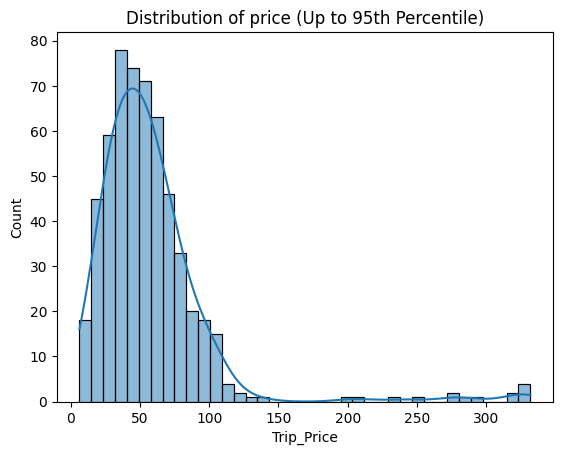

In [278]:
sns.histplot(y, kde=True)

plt.title('Distribution of price (Up to 95th Percentile)')
plt.show()

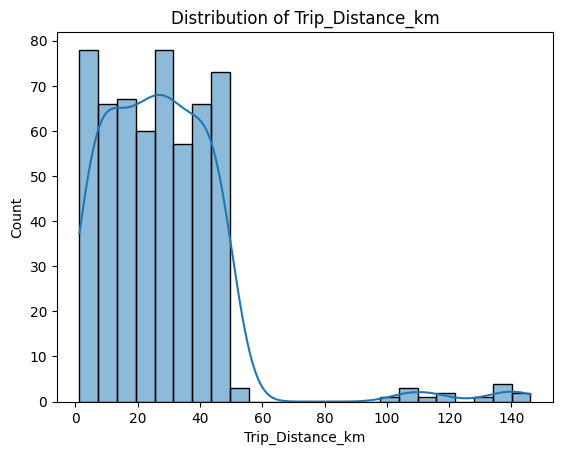

In [279]:
sns.histplot(taxi['Trip_Distance_km'], kde=True)


plt.title('Distribution of Trip_Distance_km')
plt.show()

In [280]:
# Get predictions on new input
new_df = pd.DataFrame({'Trip_Distance_km': [15, 20, 40, 80, 100, 135]})
new_X = model.transform(new_df)  # Aggiungi una colonna di 1 per l'intercetta
new_X

,intercept,Trip_Distance_km
0,1.0,15
1,1.0,20
2,1.0,40
3,1.0,80
4,1.0,100
5,1.0,135


In [281]:
New_X = sm.add_constant(new_df)
new_predictions = results.get_prediction(new_X)
predicted_means = new_predictions.predicted_mean
print(predicted_means)

[ 34.75728805  43.72399235  79.59080956 151.32444396 187.19126117
 249.95819128]


In [282]:
#Confidence interval
new_predictions.conf_int(alpha=0.05)

array([[ 32.60510923,  36.90946688],
       [ 41.761448  ,  45.6865367 ],
       [ 77.46284904,  81.71877007],
       [146.41415165, 156.23473628],
       [180.63251969, 193.75000264],
       [240.43325752, 259.48312503]])

In [283]:
intercept = results.params.iloc[0]  # Intercetta (b)
slope = results.params.iloc[1]  # Pendenza (m)

formula = f"y = {slope:.4f} * Trip_Distance_km + {intercept:.4f}"

print("FORMULA del modello di regressione:", formula)

FORMULA del modello di regressione: y = 1.7933 * Trip_Distance_km + 7.8572


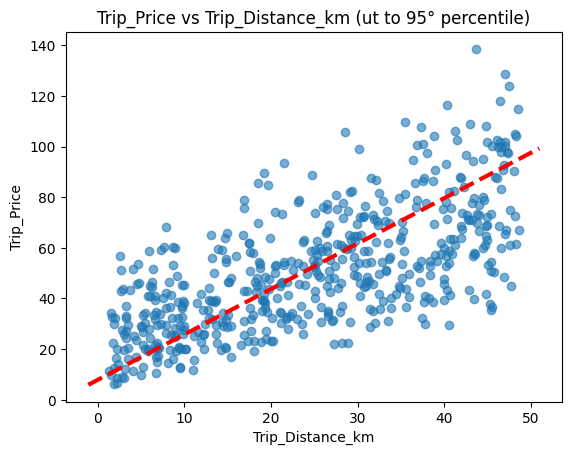

In [284]:
threshold = taxi['Trip_Distance_km'].quantile(0.95)

filtered_data = taxi[taxi['Trip_Distance_km'] <= threshold]

def abline(ax, b, m, *args, **kwargs):
    "Aggiungi una retta con pendenza m e intercetta b su ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

ax = plt.gca()
ax.scatter(filtered_data['Trip_Distance_km'], filtered_data[target], alpha=0.6)

abline(ax, intercept, slope, 'r--', linewidth=3)

plt.title("Trip_Price vs Trip_Distance_km (ut to 95° percentile)")
plt.xlabel("Trip_Distance_km")
plt.ylabel("Trip_Price")
plt.show()

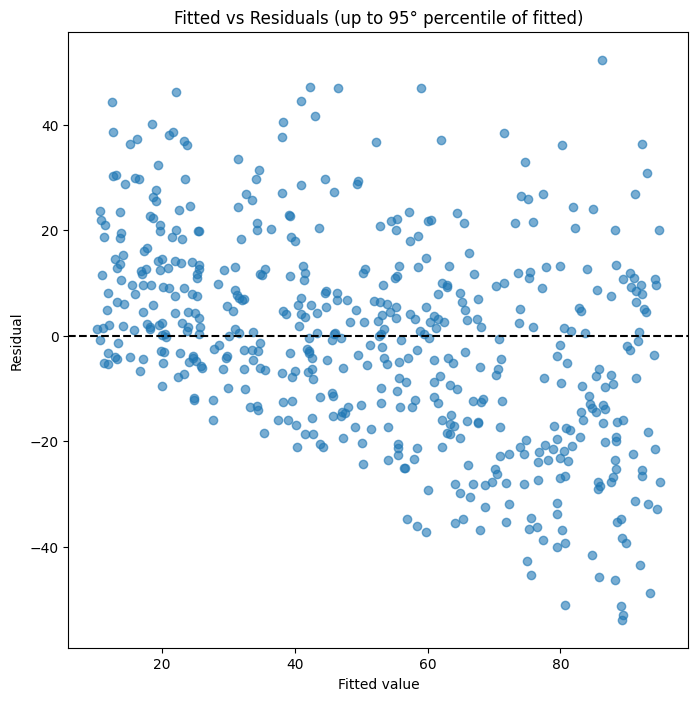

In [285]:
fitted_95 = results.fittedvalues.quantile(0.95)

mask = results.fittedvalues <= fitted_95
fitted_filtered = results.fittedvalues[mask]
resid_filtered = results.resid[mask]

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(fitted_filtered, resid_filtered, alpha=0.6)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')
ax.set_title("Fitted vs Residuals (up to 95° percentile of fitted)")
plt.show()


33

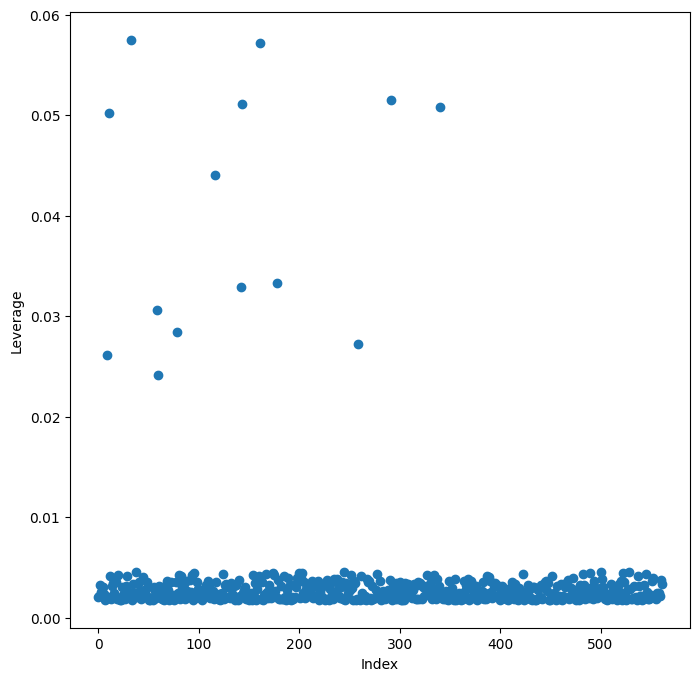

In [286]:
# Compute leverage statistics
infl = results.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

# Multiple Linear Regression

In [287]:
# y = b*X + e (perform a regression using all of the predictors)
numeric_data = taxi.select_dtypes(include=[np.number])
terms = numeric_data.drop(columns=[target])
print(terms.columns)

Index(['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 'Per_Km_Rate',
       'Per_Minute_Rate', 'Trip_Duration_Minutes'],
      dtype='object')


In [288]:
X = MS(terms).fit_transform(taxi)
model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,-60.0783,3.853,-15.594,0.000
Trip_Distance_km,1.8103,0.030,60.882,0.000
Passenger_Count,-0.1837,0.574,-0.320,0.749
Base_Fare,0.3493,0.724,0.482,0.630
Per_Km_Rate,25.6097,1.472,17.404,0.000
Per_Minute_Rate,59.5953,5.496,10.844,0.000
Trip_Duration_Minutes,0.2958,0.020,15.061,0.000


In [289]:
significant_vars = results.pvalues[results.pvalues < 0.05]
print("\nVariabili significative (p-value < 0.05):")
print(significant_vars)

insignificant_vars = results.pvalues[results.pvalues >= 0.05]
print("\nVariabili insignificanti (p-value >= 0.05):")
print(insignificant_vars)


Variabili significative (p-value < 0.05):
intercept                 9.843373e-46
Trip_Distance_km         7.827045e-248
Per_Km_Rate               1.854822e-54
Per_Minute_Rate           5.577982e-25
Trip_Duration_Minutes     3.134659e-43
dtype: float64

Variabili insignificanti (p-value >= 0.05):
Passenger_Count    0.749100
Base_Fare          0.629787
dtype: float64


In [290]:
# getting goodness of fit
print("R2", results.rsquared)
print("RSE", np.sqrt(results.scale))

R2 0.8868520330875855
RSE 14.86632301625149


In [291]:
minus_var = terms.drop(columns=['Passenger_Count', 'Base_Fare'])
Xma = MS(minus_var).fit_transform(taxi)
model1 = sm.OLS(y, Xma)
results1 = model1.fit()
summarize(results1)

,coef,std err,t,P>|t|
intercept,-59.2456,2.820,-21.011,0.0
Trip_Distance_km,1.8107,0.030,61.026,0.0
Per_Km_Rate,25.5711,1.461,17.502,0.0
Per_Minute_Rate,59.4039,5.467,10.866,0.0
Trip_Duration_Minutes,0.2961,0.020,15.129,0.0


In [292]:
significant_vars = results1.pvalues[results1.pvalues < 0.05]
print("\nVariabili significative (p-value < 0.05):")
print(significant_vars)

insignificant_vars = results1.pvalues[results1.pvalues >= 0.05]
print("\nVariabili insignificanti (p-value >= 0.05):")
print(insignificant_vars)


Variabili significative (p-value < 0.05):
intercept                 1.299132e-72
Trip_Distance_km         7.731821e-249
Per_Km_Rate               5.598880e-55
Per_Minute_Rate           4.478738e-25
Trip_Duration_Minutes     1.436244e-43
dtype: float64

Variabili insignificanti (p-value >= 0.05):
Series([], dtype: float64)


In [293]:
print("R2", results1.rsquared)
print("RSE", np.sqrt(results1.scale))

R2 0.8867884527253155
RSE 14.843777794820102


## Interaction Terms

In [294]:
# to introduce and interactions terms use a python tuple
X = MS(['lstat', 'age', ('lstat', 'age')]).fit_transform(Boston)
model2 = sm.OLS(y, X)
summarize(model2.fit())

NameError: name 'Boston' is not defined

## Non-linear Transformations of the Predictors

In [ ]:
# poly() function present in the package ISLP specifies that columns representing polynomial functions of its first argument are added to the model matrix
X = MS([poly('lstat', degree=2), 'age']).fit_transform(Boston)
model3 = sm.OLS(y, X)
results3 = model3.fit()
summarize(results3)

## Qualitative predictors
Based on the Carseats dataset present in the package ISLP, will attempt to predict Sales (child car seat sales) in 400 locations based
on a number of predictors.

The Carseats data includes the qualitative predictor "ShelveLoc," which indicates the quality of the shelving location with three possible values: Bad, Medium, and Good.

In general for qualitative predictor the ModelSpec() generates one-hot encoding of the categorical variables automatically

In [ ]:
Carseats = load_data('Carseats')
Carseats.columns

In [ ]:
allvars = list(Carseats.columns.drop('Sales'))
y = Carseats['Sales']
final = allvars + [('Income', 'Advertising'),
('Price', 'Age')]
X = MS(final).fit_transform(Carseats)
model = sm.OLS(y, X)
summarize(model.fit())

# Cross Validation

### Validation set approach

In [ ]:
from functools import partial
from sklearn.model_selection import (cross_validate ,KFold ,ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm #a wrapper that enables us to easily use the cross-validation tools of sklearn with models fit by statsmodels
from sklearn.model_selection import train_test_split

In [ ]:
Auto = load_data('Auto')
Auto_train , Auto_valid = train_test_split(Auto, test_size=196, random_state=0) # random_state is needed for reproducible result across run

In [ ]:
#fit a linear regression model
hp_mm = MS(['horsepower'])
X_train = hp_mm.fit_transform(Auto_train)
y_train = Auto_train['mpg']
model = sm.OLS(y_train , X_train)
results = model.fit()

In [ ]:
# evaluate the model using the MSE on the validation data
X_valid = hp_mm.transform(Auto_valid)
y_valid = Auto_valid['mpg']
valid_pred = results.predict(X_valid)
np.mean((y_valid - valid_pred)**2)

## Leave One-out Cross validation
The sklearn_sm() class takes a statsmodels model as its first argument. It also accepts two optional arguments: model_str for specifying a formula, and model_args, which is a dictionary containing additional arguments for fitting the model.

In [ ]:
hp_model = sklearn_sm(sm.OLS, MS(['horsepower']))
X, Y = Auto.drop(columns=['mpg']), Auto['mpg']

# This is a LOOCV because cv use the number of sample in our dataset, that is Auto.shape[0], making sure that each sample is use as a test set
cv_results = cross_validate(hp_model ,X, Y, cv=Auto.shape[0])
cv_err = np.mean(cv_results['test_score'])
cv_err

## K-Fold cross validation

In [ ]:
hp_model = sklearn_sm(sm.OLS, MS(['horsepower']))
X, Y = Auto.drop(columns=['mpg']), Auto['mpg']
kf = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_validate(hp_model, X, Y, cv=kf)
cv_err = np.mean(cv_results['test_score'])
cv_err

# Exercise
Train and compare the performance of different cross-validation methods to identify the best model for polynomial regression with varying degrees using the Auto dataset.

https://scikit-learn.org/stable/

Fine